### Speech recognition example
##### Raymundo Gonzalez Leal

In [61]:
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt

In [62]:
A_train_path = 'symbol/language-training-langA-'
B_train_path = 'symbol/language-training-langB-'
C_train_path = 'symbol/language-training-langC-'
test_path = 'symbol/language-test-'

In [63]:
A_text = ''
for i in range(30):
    file_num = str(i)
    this_path = A_train_path + file_num     
    A_text =  A_text + 'S' +  open(this_path, 'r').read() + 'F'

B_text = ''
for i in range(30):
    file_num = str(i)
    this_path = B_train_path + file_num     
    B_text = B_text + 'S' + open(this_path, 'r').read() + 'F'

C_text = ''
for i in range(30):
    file_num = str(i)
    this_path = C_train_path + file_num     
    C_text = C_text + 'S'+ open(this_path, 'r').read() + 'F'
    
test_list = []
for i in range(9):
    file_num = str(i)
    this_path = test_path + file_num
    test_list.append('S'+ open(this_path, 'r').read() + 'F')

Note that we added the S and F to indicate the beginning and end of every sentence. This way we are implcitly modeling the length of the sentences, and we are showing which letters are most likely to be right before the end of a sentence or right after the beginning (which seems important if we don't know how the text was generated).

In [86]:
index_list = ['S', 'F', 'A', 'o', 'e', 't', 'p', 'g', 'k']

### Creating transition matrices for each speaker. 


M_A = [ [0 for j in range(len(index_list))] for i in range(len(index_list)) ]
for char_ind in range(len(A_text)-1):
    i  =  index_list.index(A_text[char_ind])
    j  =  index_list.index(A_text[char_ind + 1])    
    M_A[i][j] += 1.0 
for k in range(len(M_A)):
    M_A[k] = np.asarray(M_A[k]) / sum(np.asarray(M_A[k])) 
    
M_B = [ [0 for j in range(len(index_list))] for i in range(len(index_list)) ]
for char_ind in range(len(B_text)-1):
    i  =  index_list.index(B_text[char_ind])
    j  =  index_list.index(B_text[char_ind + 1])    
    M_B[i][j] += 1.0 
for k in range(len(M_B)):
    M_B[k] = np.asarray(M_B[k]) / sum(np.asarray(M_B[k])) 
    
M_C = [ [0 for j in range(len(index_list))] for i in range(len(index_list)) ]
for char_ind in range(len(C_text)-1):
    i  =  index_list.index(C_text[char_ind])
    j  =  index_list.index(C_text[char_ind + 1])    
    M_C[i][j] += 1.0 
for k in range(len(M_C)):
    M_C[k] = np.asarray(M_C[k]) / sum(np.asarray(M_C[k])) 

In [87]:
M_C

[array([ 0.        ,  0.        ,  0.23333333,  0.16666667,  0.1       ,
         0.16666667,  0.1       ,  0.16666667,  0.06666667]),
 array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([ 0.        ,  0.00700935,  0.61682243,  0.06775701,  0.05373832,
         0.04672897,  0.08411215,  0.07009346,  0.05373832]),
 array([ 0.        ,  0.00917431,  0.06651376,  0.61009174,  0.05275229,
         0.06880734,  0.08256881,  0.05045872,  0.05963303]),
 array([ 0.        ,  0.00696056,  0.05800464,  0.05568445,  0.60324826,
         0.07192575,  0.07424594,  0.05800464,  0.07192575]),
 array([ 0.        ,  0.01128668,  0.06772009,  0.05869074,  0.06997743,
         0.59142212,  0.06320542,  0.07900677,  0.05869074]),
 array([ 0.        ,  0.01103753,  0.0419426 ,  0.07064018,  0.08830022,
         0.07064018,  0.59161148,  0.08609272,  0.0397351 ]),
 array([ 0.        ,  0.01598174,  0.07990868,  0.05707763,  0.06849315,
         0.07305936,  0.05022831,  0.5913242 ,  0.06392694]),


In [107]:
len(test_list)

9

By bayes rule $ P(M | D) \propto P(D | M) * P(M) $

If we assign equal priors to all models, this means we'll classify by looking for the model with the highest likelihood

In [98]:
def classify(text, M_list = [M_A, M_B, M_C]):
    
    Likelihoods = [1 for i in range(len(M_list))]
    for M_ind in range(len(M_list)):        
        for char_ind in range(len(text)-1):
            i  =  index_list.index(text[char_ind])
            j  =  index_list.index(text[char_ind + 1])
            
            this_fact = M_list[M_ind][i][j]
            Likelihoods[M_ind] = Likelihoods[M_ind] * this_fact
        
    return Likelihoods
    

Here are our models classifications for the test set:

In [222]:
for test in test_list:
    print classify(test).index(max(classify(test)))
   

2
2
0
1
0
0
1
0
2


## Problem 2

There are three people in a room. Each says about 10 phonemes, before being randomly interrupted by someone else. When they speak they all sound the same, however each person tends to use different phonemes in their speech. Specifically we can model the following transition probabilities that someone will interrupt the current speaker: P(speaker i at time t+1 | speaker j at time t). We can also model the probability over phonemes given a particular speaker: P(phoneme | speaker i). The phonemes are identical to the ones introduced in problem 1 (but the transition matrices are obviously different, since they take a different form altogether).

Write down the update equations that you will need to train a hidden Markov model. Using the information given above, write down a sensible initialization for the transition matrix.

##### $\alpha$ recursion

From Barber 23.2:

$ \alpha(h_t) = p(h_t | v_{1:t}) = p(v_t | h_t) \sum_{h_{t-1}} p(h_t | h_{t-1}) \alpha(h_{t-1})  $

with $\alpha(h_1) = p(v_1 | h_1) p(h_1)$


##### $\beta$ recursion

$ \beta(h_{t-1}) = \sum_{h_t} p(v_t | h_t) p(h_t | h_{t-1}) \beta(h_t) $  

where

$2 \leq t \leq T$

and

$\beta(h_T) = 1 $


Combining our $\alpha $ and $\beta$ recursions, we can calculate the posterior over the hidden states at any time through the gamma function:

$ P(h_t | v_{1:T}) \equiv \gamma(h_t) = \frac{\alpha(h_t) \beta(h_t)}{\sum_{h_t} \alpha(h_t) \beta(h_t)} $





Here I will use the hmmlearn package to train a HMM. I will compute the probabilities for each hidden state at every time and plot them over time.

In [92]:
speaker_data = open('speaker.txt', 'r').read()

In [93]:
n_observations = 7
observations = ['A', 'o', 'e', 't', 'p', 'g', 'k']

multinomial_data = []
for i in speaker_data: multinomial_data.append(observations.index(i))
multinomial_data = np.asarray(multinomial_data).reshape(-1, 1)


In [207]:
n_states = 3
start_probability= np.array([1.0/3, 1.0/3, 1.0/3])

transition_probability = np.array([
  [0.9, 0.05, 0.05],
  [0.05, 0.9, 0.05],
  [0.05, 0.05, 0.9]       
])

model = hmm.MultinomialHMM(n_components= n_states)
model.startprob=start_probability
model.transmat=transition_probability
model.fit(multinomial_data)
model.decode(multinomial_data)

(-1964.5407857483397,
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0,
        0, 2, 2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
        1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1

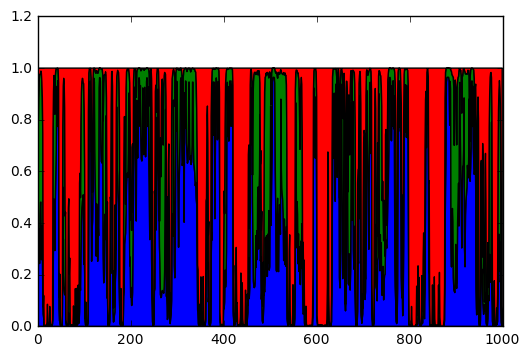

In [208]:
probs = model.predict_proba(np.asarray(multinomial_data))
probs0 = [i[0] for i in probs]
probs1 = [i[1] for i in probs]
probs2 = [i[2] for i in probs]

x = np.arange(len(speaker_data))
fig, ax = plt.subplots()
ax.stackplot(x, probs0, probs1, probs2)
plt.show()

Now I will try to make my own implementation

Note: Implementation is based on Guy's file on the slack channel (which had the general structure but did not show most of the implemented functions).

Second note: I realized too late that the assignment description for this problem was to make our own implementation (I thought using hmmlearn would be enough). I was not able to complete this implementation.


In [122]:
ALPHABET = ['A', 'o', 'e', 't', 'p', 'g', 'k']

data = open('speaker.txt').read() 
transitions = list(zip(data, data[1:]))
mapping = {letter: index for (index, letter) in enumerate(ALPHABET)}
mapped_data = [mapping[v] for v in data]
mapped_transitions = [(mapping[a], mapping[b]) for (a, b) in transitions]

a = np.array([1.0/3, 1.0/3, 1.0/3])
A = A = np.array([
  [0.9, 0.05, 0.05],
  [0.05, 0.9, 0.05],
  [0.05, 0.05, 0.9]       
])

B = []
for i in range(3):
    this_B = np.random.uniform(0,1,7)
    this_B = this_B / sum(this_B)
    B.append(this_B)


$ \alpha(h_t) = p(h_t | v_{1:t}) = p(v_t | h_t) \sum_{h_{t-1}} p(h_t | h_{t-1}) \alpha(h_{t-1})  $

with $\alpha(h_1) = p(v_1 | h_1) p(h_1)$

In [220]:
def alpha(a, A, B, mapped_data):    
    ans = []
    for t in range(len(mapped_data)):
        this_a = []
        for i in range(len(a)):
            p_v_given_h = B[i][mapped_data[t]]           
            if t == 0:
                p_h = a[i]
                this_a.append(p_v_given_h * p_h)            
            else: 
                #Sum over every previous value
                p_h = 0
                for j in range(len(ans[-1])):
                    p_h += A[j][i] * ans[-1][j]           
                this_a.append(p_v_given_h * p_h)         
        ans.append(this_a)
    return ans    

$ \beta(h_{t-1}) = \sum_{h_t} p(v_t | h_t) p(h_t | h_{t-1}) \beta(h_t) $  

where

$2 \leq t \leq T$

and

$\beta(h_T) = 1 $

In [ ]:
def beta(a, A, B, mapped_data):
    
    ans = [[] for i in range(len(mapped_data))]
    ans[-1] = [1,1,1]   
    for t in range(-2, -len(mapped_data), -1):
        for i in range(len(a)):
            this_beta = 0
            for j in range(len(ans[t])):
                this_beta +=  B[j][mapped_data[t]] * A[j][i] * ans[t+1][j]
            ans[t].append(this_beta)
    return ans
    


$ \gamma(h_t) = \frac{\alpha(h_t) \beta(h_t)}{\sum_{h_t} \alpha(h_t) \beta(h_t)} $

In [ ]:
def gamma(alpha_messages, beta_messages):
    gamma = []
    for i in range(len(alpha_messages)):
        this_gamma = np.asarray(alpha_messages[i]) * np.asarray(beta_messages[i])
        this_sum = 0
        for j in range(len(alpha_messages[i])):
            this_sum += alpha_messages[i][j] * beta_messages[i][j]
        this_gamma = this_gamma/this_sum

Pairwise marginals

$ P(h_t, h_{t+1} | v_{1:T}) \propto \alpha(h_t) P(h_{t+1} | h_t) p(v_{t+1} | h_{t+1}) \beta(h_{t+1}) $

We'll make a matrix such that $M_{ij} = P(h_t = i, h_{t+1} = j | v_{1:T})$

In [ ]:
def pairwise_marginals(alpha_messages, beta_messages, mapped_data):
    
    ans = []
    
    for t in range(len(mapped_data)):
        M = [ [] for i in range(3) ]
        
        ## Need to create a matrix for every pairwise marginal of combinations of possible values
        ## for h_t and h_t+1
        
        ans.append(M)
    

The expectation step is simple if we have our alpha, beta, gamma, and pairwise marginals functions

In [ ]:
def E_step(a, A, B, mapped_data):
    alpha_messages = alpha(a, A, B, mapped_data)
    beta_messages = beta(a, A, B, mapped_data)
    
    return gamma(alpha_messages, beta_messages), \
            pairwise_marginals(alpha_messages, beta_messages, mapped_data)